In [14]:
import gym
import numpy as np
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [15]:
env = gym.make('Blackjack-v0')
observation = env.reset()
print(env.action_space, env.observation_space, sep='\n')

Discrete(2)
Tuple(Discrete(32), Discrete(11), Discrete(2))


In [16]:
def make_epsilon_greedy_policy(Q_table, nA, epsilon):
    def generate_policy(observation):
        prob_A = np.ones(nA)*epsilon / nA
        optimal_a = np.argmax(Q_table[observation])
        prob_A[optimal_a] += (1.0 - epsilon)
        return prob_A
    return generate_policy

In [17]:
def generate_one_episode(env, generate_policy):
    trajectory = []
    state = env.reset()
    for i in range(1000):
        Pi_table = generate_policy(state)
        action = np.random.choice(np.arange(len(Pi_table)), p=Pi_table)
        next_state, reward, done, _ = env.step(action)
        trajectory.append((next_state, action, reward))
        if done:
            break
        state = next_state
    return trajectory

In [18]:
def MC_control(env, iteration_times=500000, epsilon=0.1, discount_factor= 1.0):
    Return, Count, Q_table = defaultdict(float), defaultdict(float), defaultdict(lambda: np.zeros(env.action_space.n))
    policy = make_epsilon_greedy_policy(Q_table, env.action_space.n, epsilon)
    for i in range(iteration_times):
        trajectory = generate_one_episode(env, policy)
        s_a_pairs = set([(x[0], x[1]) for x in trajectory])
        for state, action in s_a_pairs:
            s_a = (state, action)
            first_visit_id = next(i for i, x in enumerate(trajectory) if x[0] == state and x[1] == action)
            G = sum([x[2]*(discount_factor**2) for i, x in enumerate(trajectory[first_visit_id:])])
            Return[s_a] += G
            Count[s_a] += 1.
            Q_table[state][action] = Return[s_a] / Count[s_a]
    return policy, Q_table

In [49]:
def MC_control2(env, iteration_times=500000, epsilon=0.1, discount_factor= 1.):
    Return, Count, Q_table = defaultdict(float), defaultdict(float), defaultdict(lambda: np.zeros(env.action_space.n))
    policy = make_epsilon_greedy_policy(Q_table, env.action_space.n, epsilon)
    for i in range(iteration_times):
        trajectory = []
        state = env.reset()
        for i in range(1000):
            Pi_table = policy(state)
            action = np.random.choice(np.arange(len(Pi_table)), p=Pi_table)
            next_state, reward, done, _ = env.step(action)
            trajectory.append((next_state, action, reward))
            if done:
                break
            state = next_state
        s_a_pairs = set([(x[0], x[1]) for x in trajectory])
        for state, action in s_a_pairs:
            s_a = (state, action)
            first_visit_id = next(i for i, x in enumerate(trajectory) if x[0] == state and x[1] == action)
            G = sum([x[2]*(discount_factor**i) for i, x in enumerate(trajectory[first_visit_id:])])
            Return[s_a] += G
            Count[s_a] += 1.
            Q_table[state][action] = Return[s_a] / Count[s_a]
    return policy, Q_table

In [47]:
def plot_value_function(Q_table):
    x = np.arange(12, 21)
    y = np.arange(1, 10)
    X, Y = np.meshgrid(x, y)
    Z_noace = np.apply_along_axis(lambda x: Q_table[(x[0], x[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda x: Q_table[(x[0], x[1], True)], 2, np.dstack([X, Y]))
    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 12))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('\nPlayer Sum', fontsize=25)
        ax.set_ylabel('\nDealer Showing', fontsize=25)
        ax.set_zlabel('\nValue', fontsize=25)
        ax.set_title('\n\n' + title, fontsize=25)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.savefig('../RL/%s.png'%title)
        plt.show()
    plot_surface(X, Y, Z_noace, '{}(not use Ace)'.format('optimal value function'))
    plot_surface(X, Y, Z_ace, '{}(use Ace)'.format('optimal Value function'))

In [50]:
optimal_policy, Q_table = MC_control(env)
V = defaultdict(float)
for state, action_value in Q_table.items():
    V[state] = np.max(action_value)

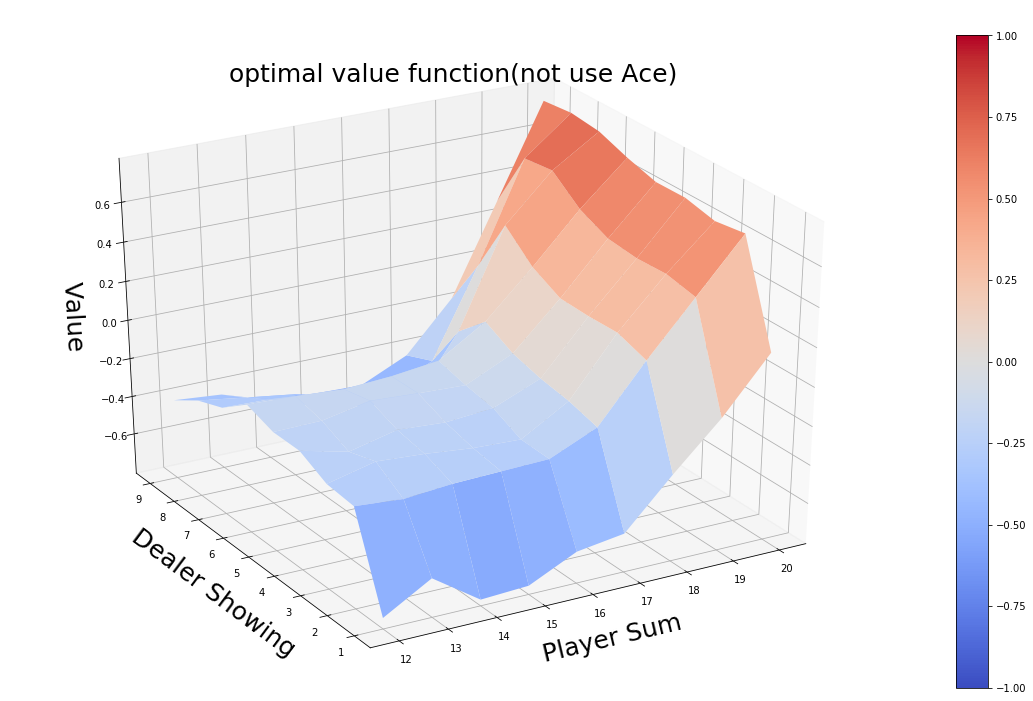

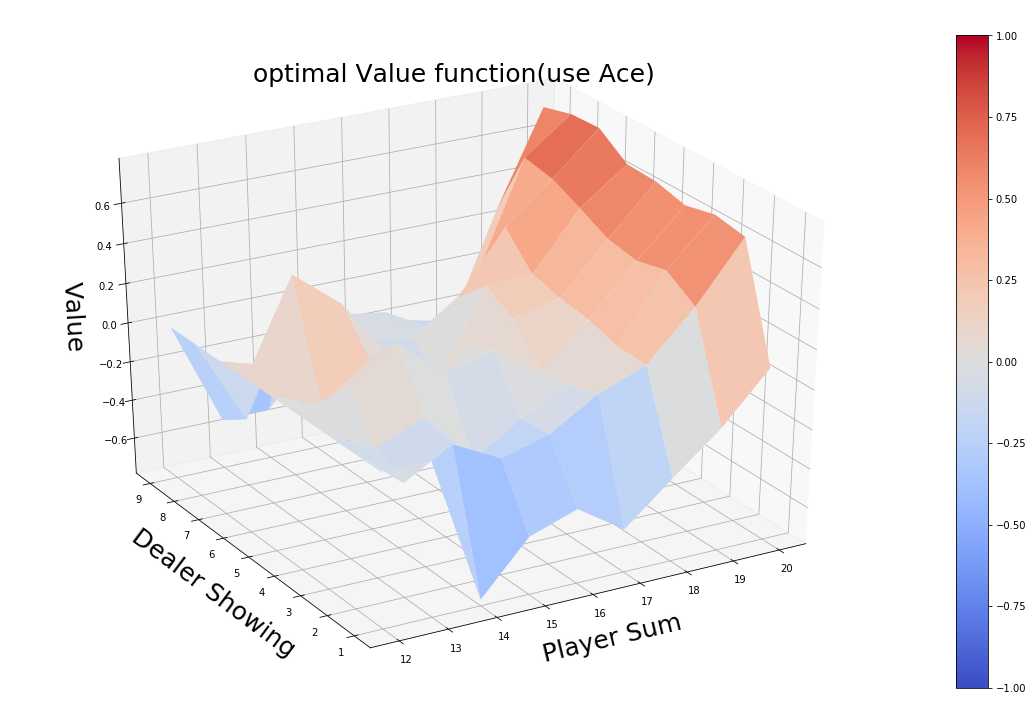

In [51]:
plot_value_function(V)